## Perform preprocessing

In [ ]:
# download the dataset
!kaggle datasets download -d protobioengineering/mit-bih-arrhythmia-database-modern-2023 -p ./data --unzip


'MLII' data not found in 100_annotations_1.csv


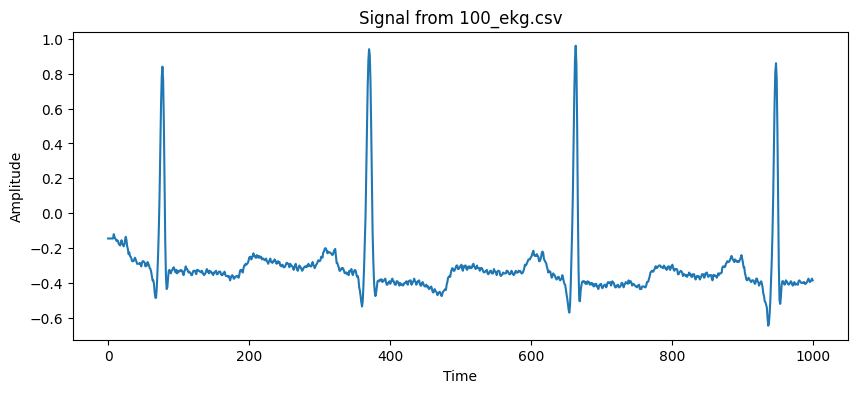

'MLII' data not found in 101_annotations_1.csv


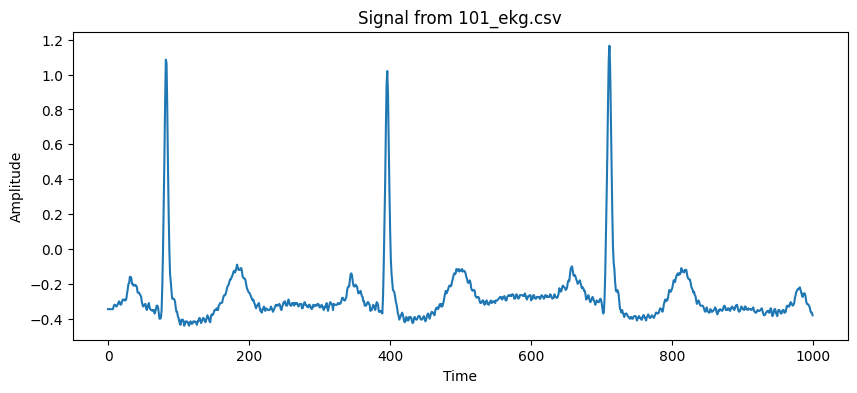

'MLII' data not found in 102_annotations_1.csv
'MLII' data not found in 102_ekg.csv
'MLII' data not found in 103_annotations_1.csv


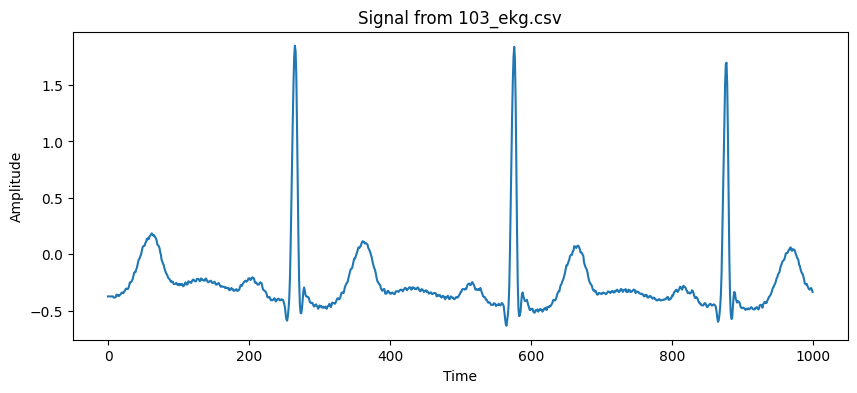

'MLII' data not found in 104_annotations_1.csv
'MLII' data not found in 104_ekg.csv
'MLII' data not found in 105_annotations_1.csv


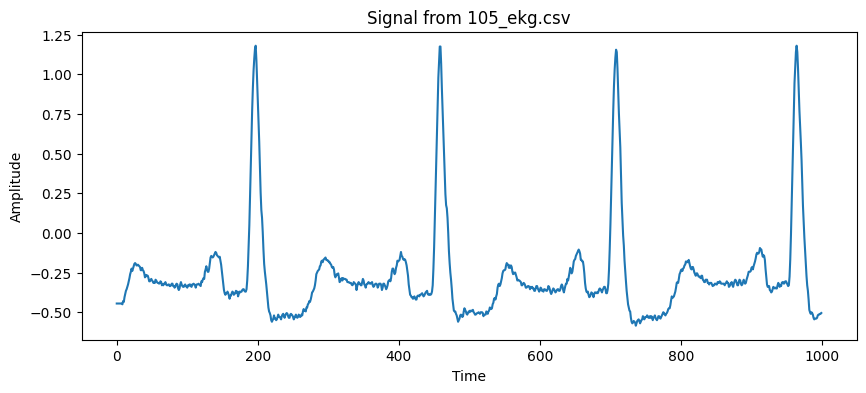

'MLII' data not found in 106_annotations_1.csv


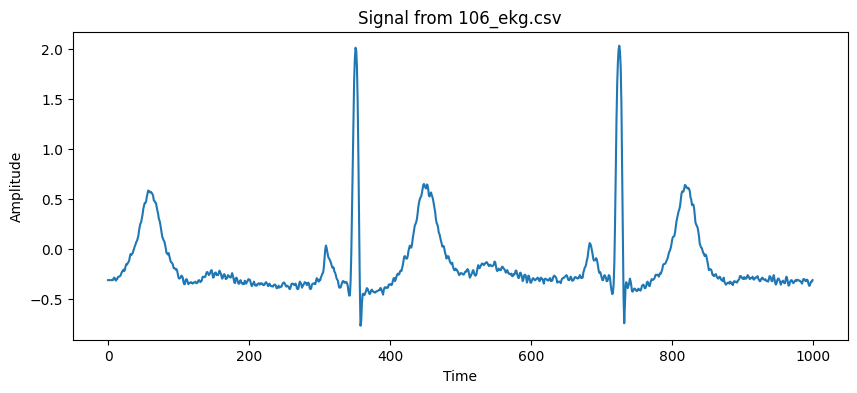

'MLII' data not found in 107_annotations_1.csv


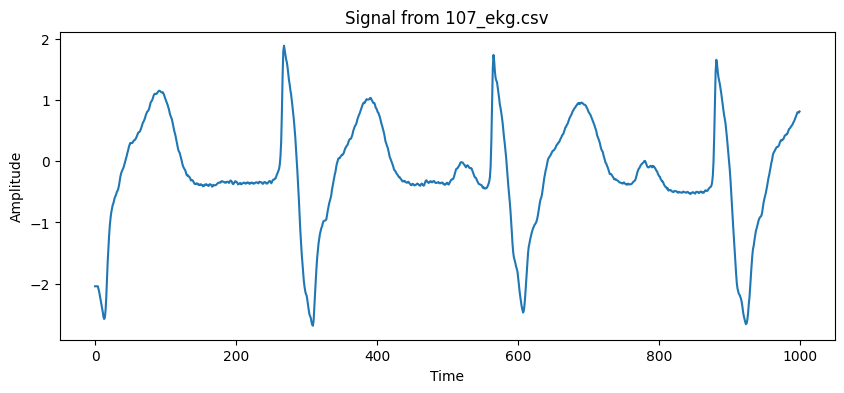

'MLII' data not found in 108_annotations_1.csv
'MLII' data not found in 108_annotations_2.csv


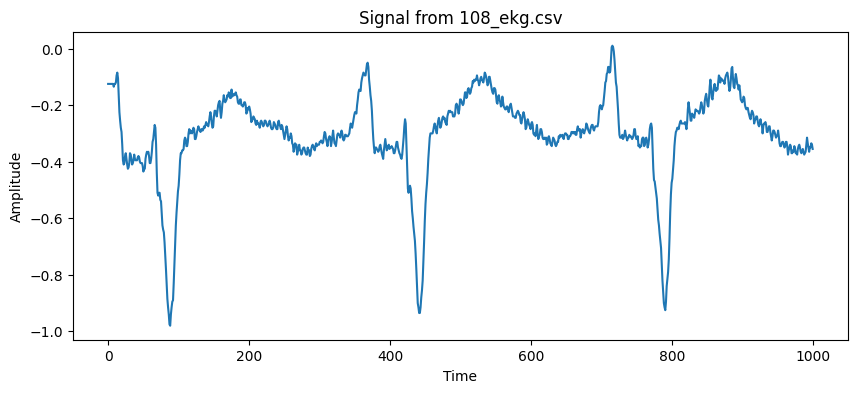

'MLII' data not found in 109_annotations_1.csv


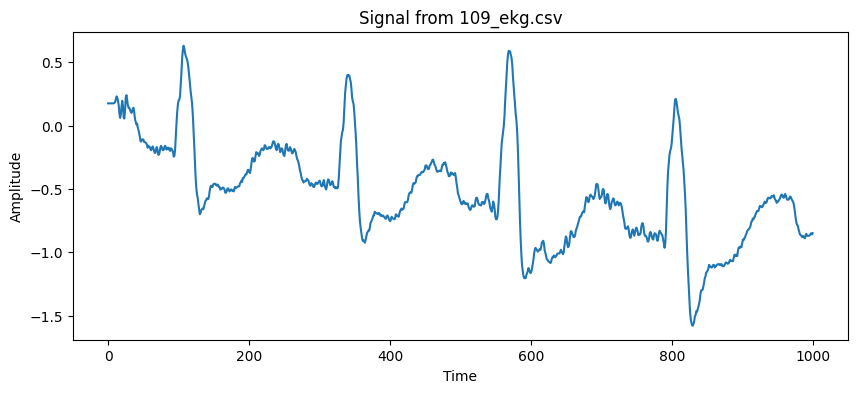

'MLII' data not found in 111_annotations_1.csv


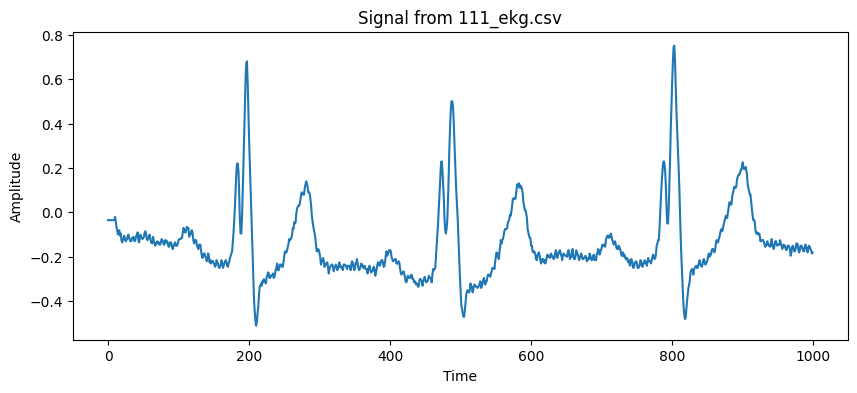

'MLII' data not found in 112_annotations_1.csv


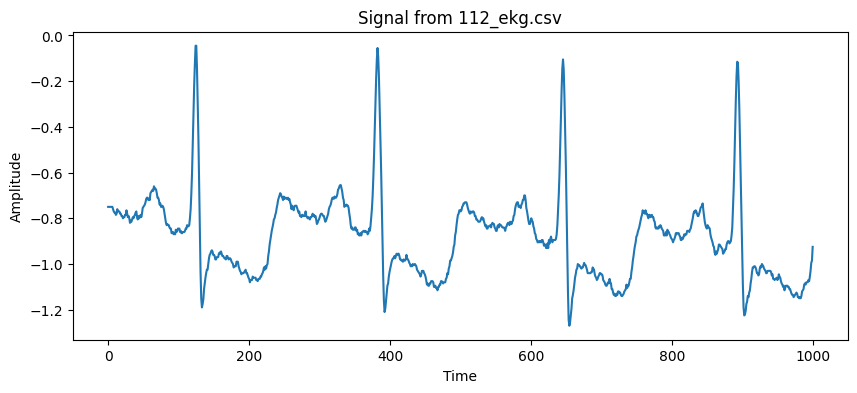

'MLII' data not found in 113_annotations_1.csv


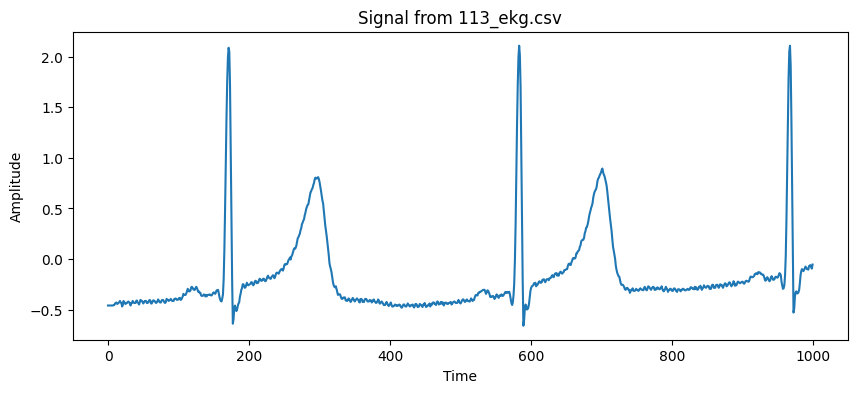

'MLII' data not found in 114_annotations_1.csv


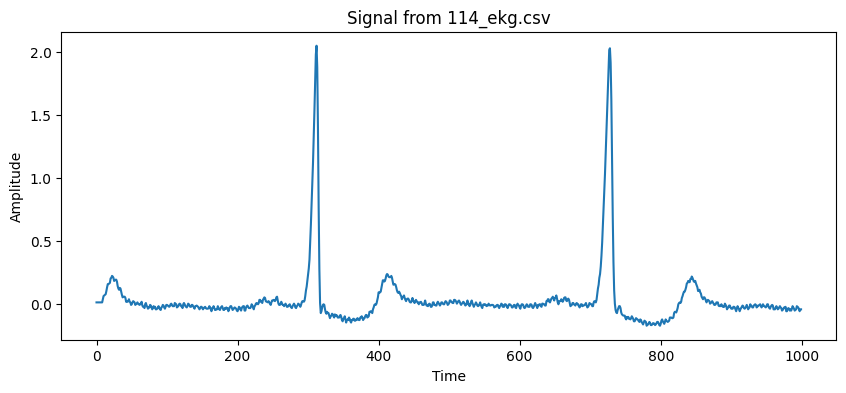

'MLII' data not found in 115_annotations_1.csv


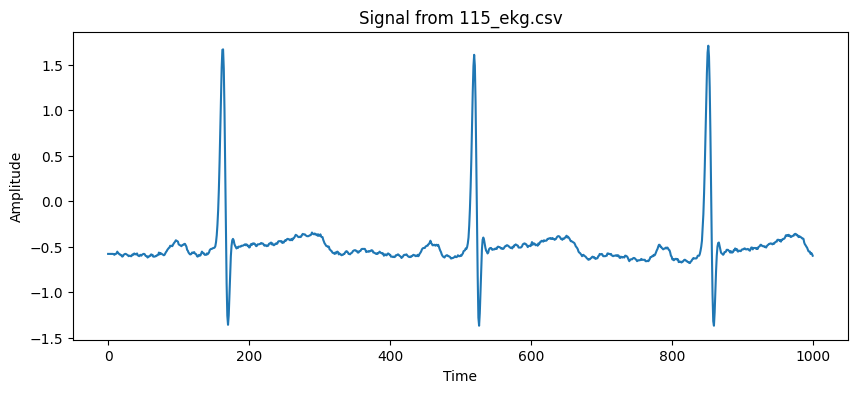

'MLII' data not found in 116_annotations_1.csv


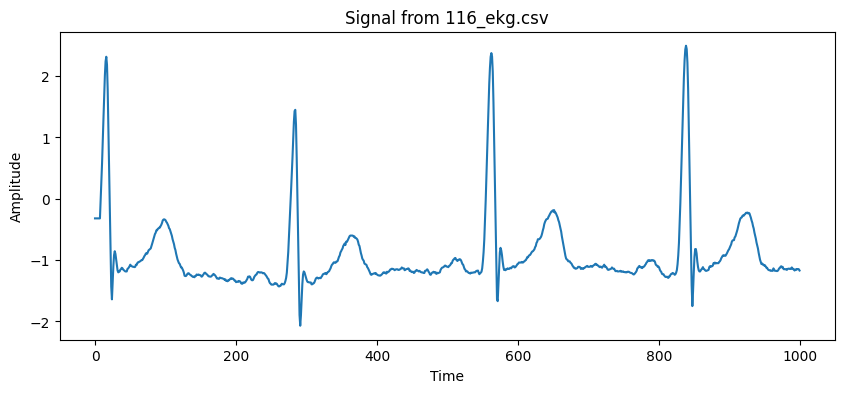

'MLII' data not found in 117_annotations_1.csv
'MLII' data not found in 117_annotations_2.csv


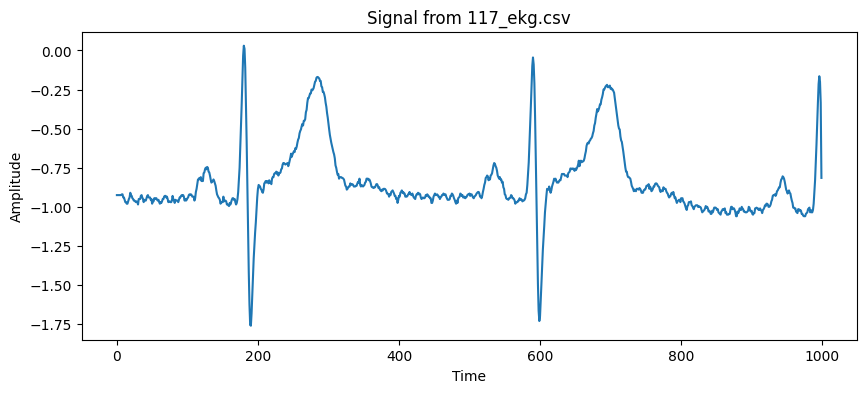

'MLII' data not found in 118_annotations_1.csv


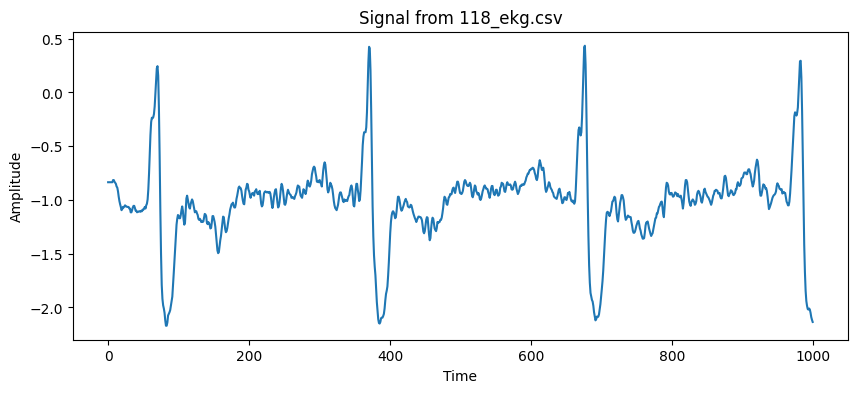

'MLII' data not found in 119_annotations_1.csv
'MLII' data not found in 119_annotations_2.csv


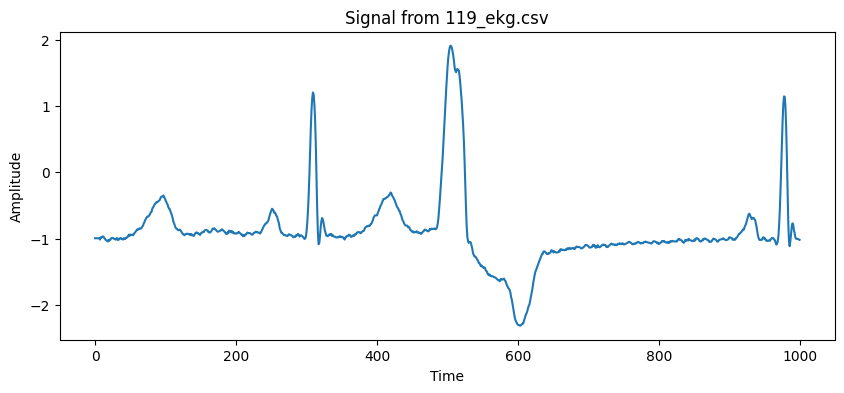

'MLII' data not found in 121_annotations_1.csv


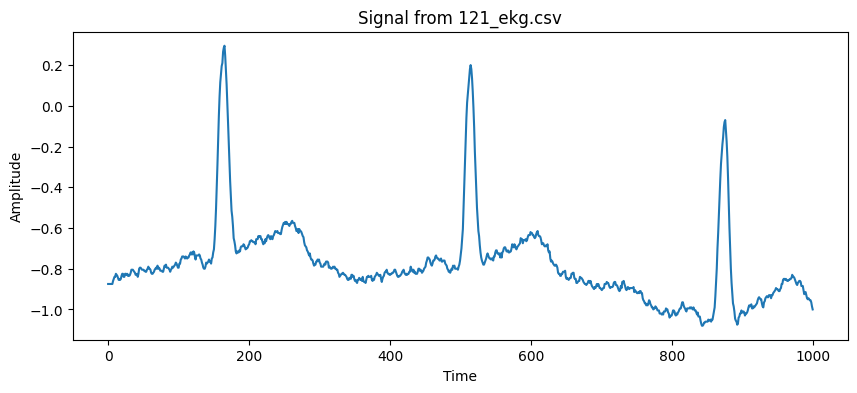

'MLII' data not found in 122_annotations_1.csv


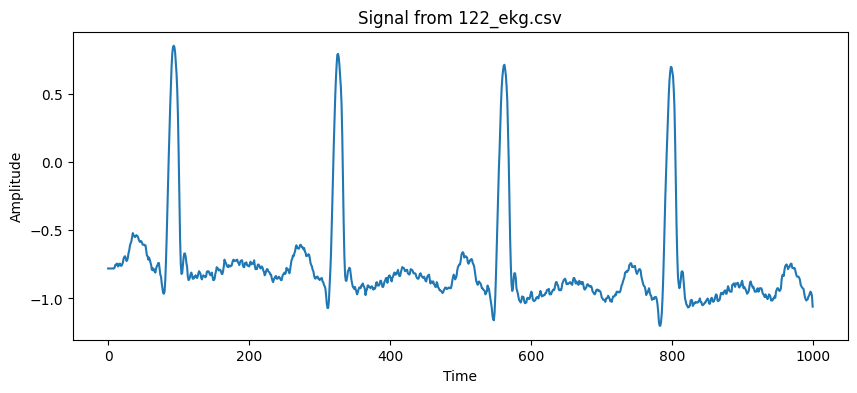

'MLII' data not found in 123_annotations_1.csv


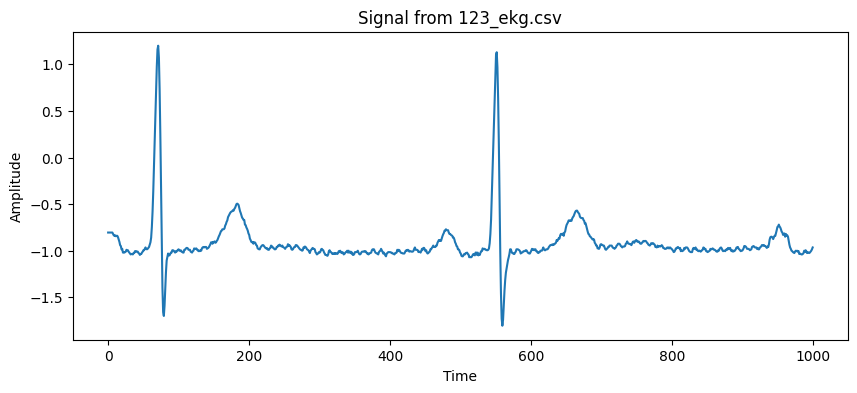

'MLII' data not found in 124_annotations_1.csv


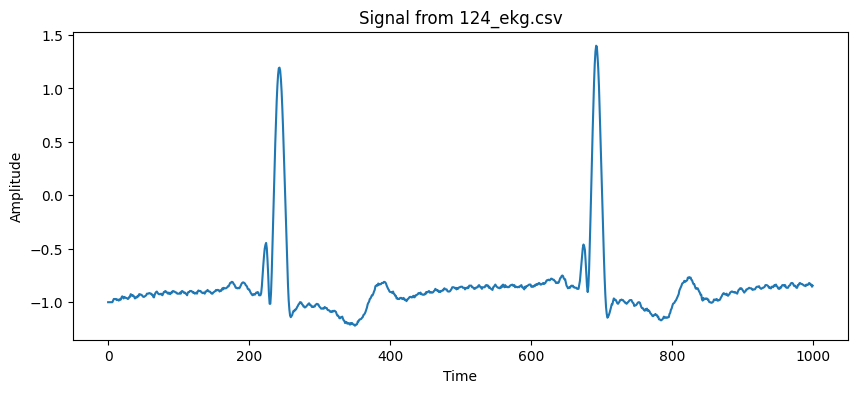

'MLII' data not found in 200_annotations_1.csv


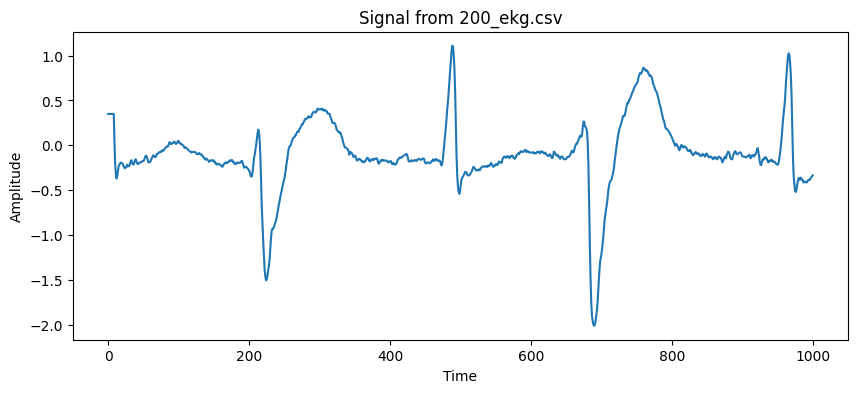

'MLII' data not found in 201_annotations_1.csv


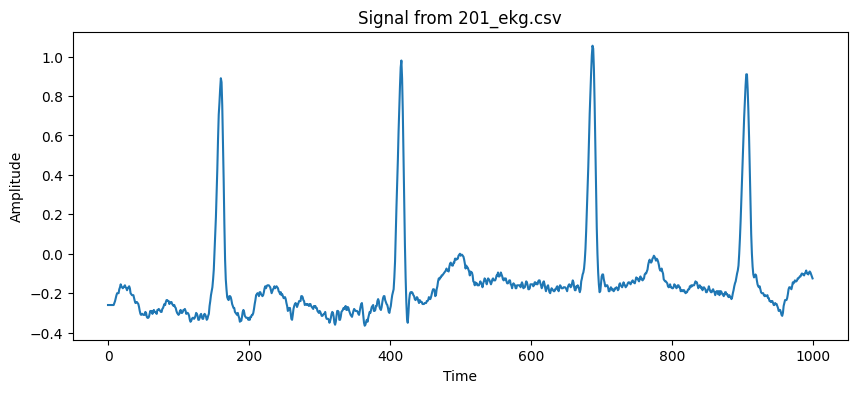

'MLII' data not found in 202_annotations_1.csv


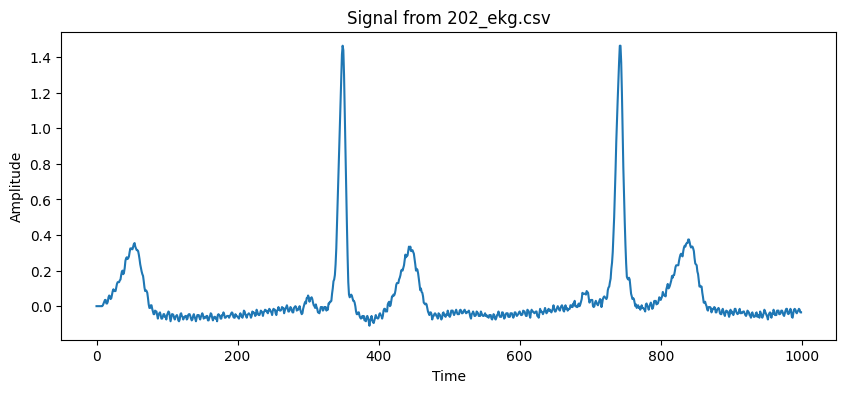

'MLII' data not found in 203_annotations_1.csv
'MLII' data not found in 203_annotations_2.csv
'MLII' data not found in 203_annotations_3.csv


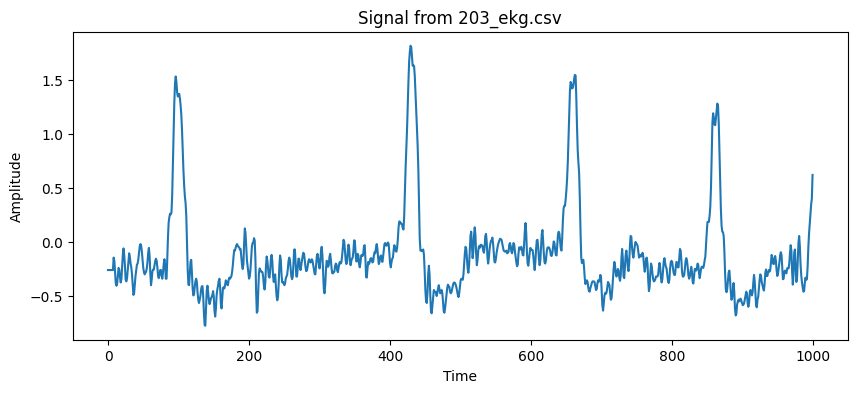

'MLII' data not found in 205_annotations_1.csv


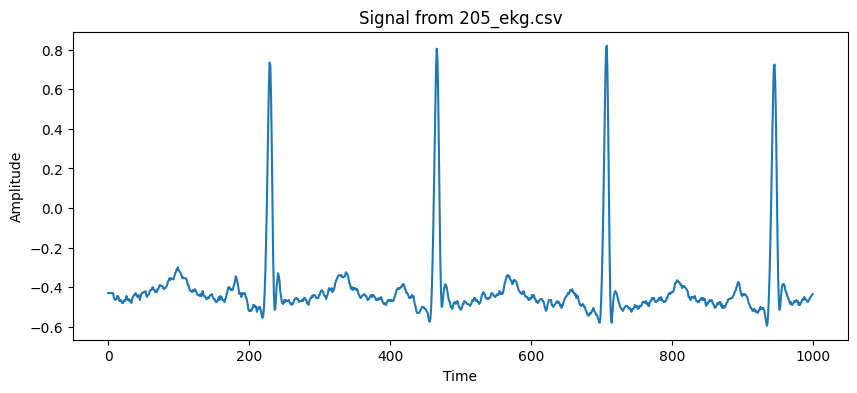

'MLII' data not found in 207_annotations_1.csv


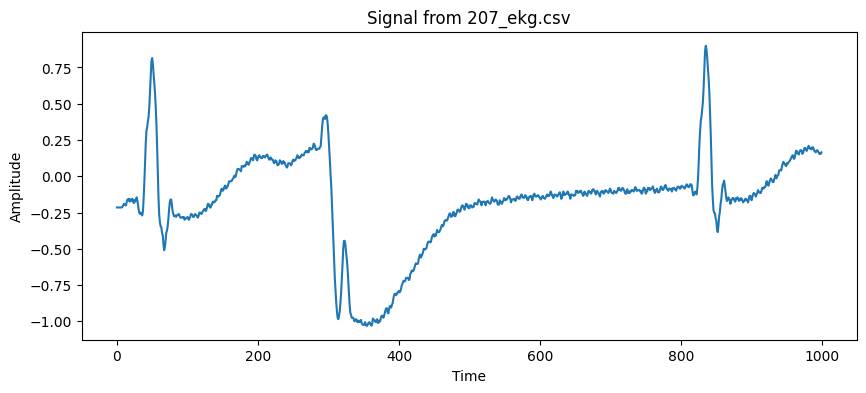

'MLII' data not found in 208_annotations_1.csv


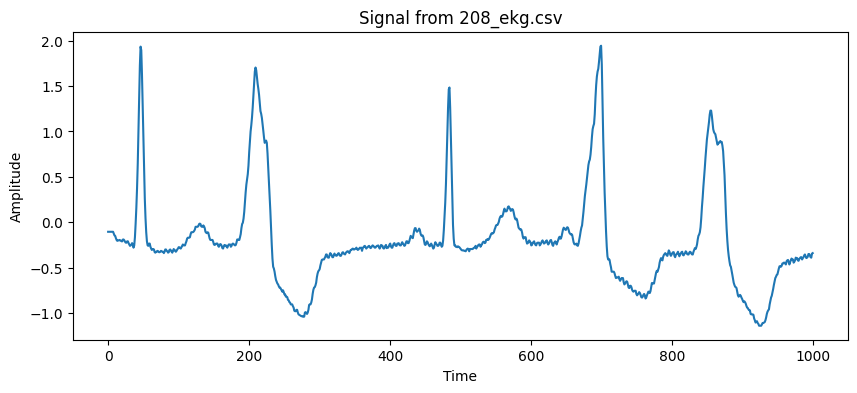

'MLII' data not found in 209_annotations_1.csv
'MLII' data not found in 209_annotations_2.csv


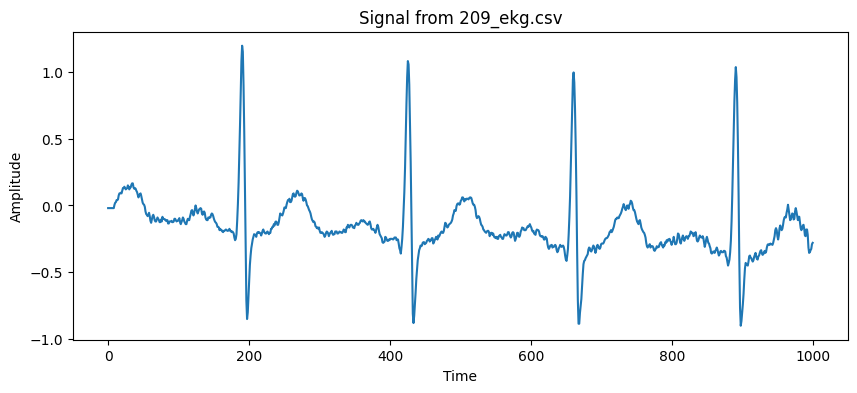

'MLII' data not found in 210_annotations_1.csv


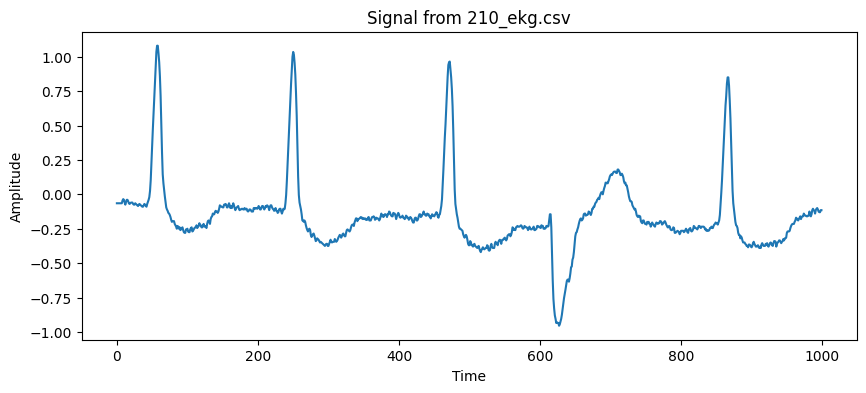

'MLII' data not found in 212_annotations_1.csv


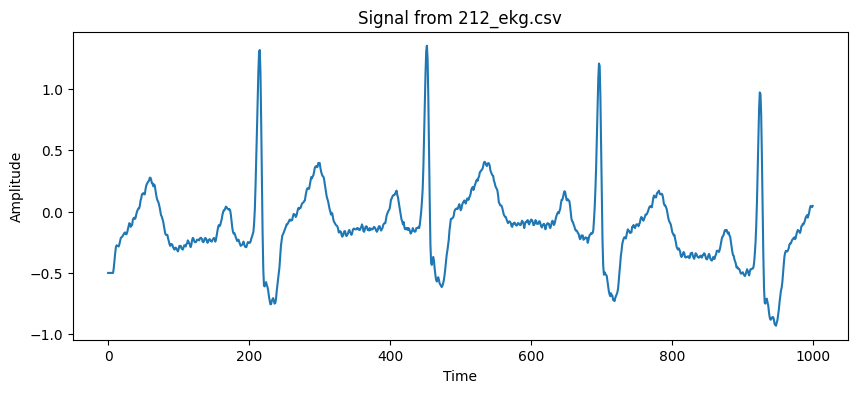

'MLII' data not found in 213_annotations_1.csv


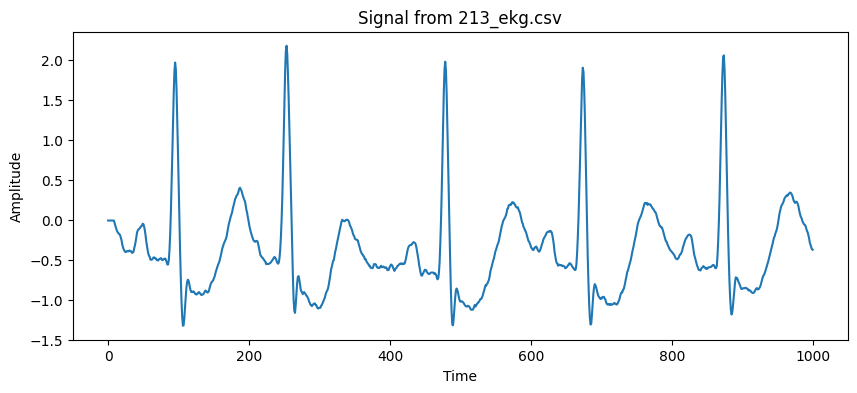

'MLII' data not found in 214_annotations_1.csv
'MLII' data not found in 214_annotations_2.csv


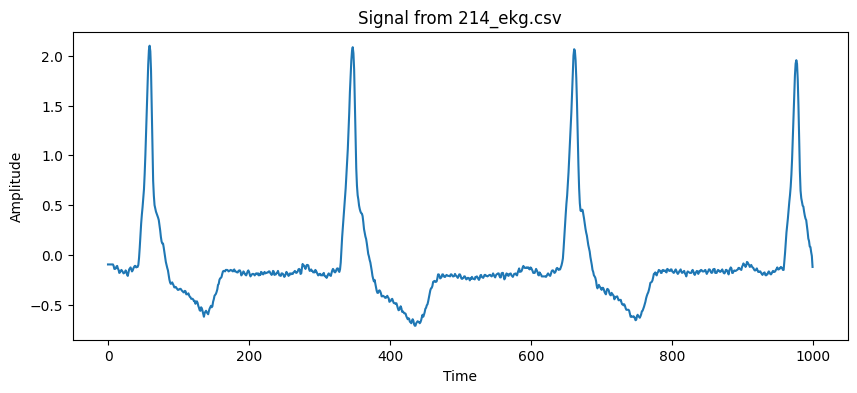

'MLII' data not found in 215_annotations_1.csv
'MLII' data not found in 215_annotations_2.csv


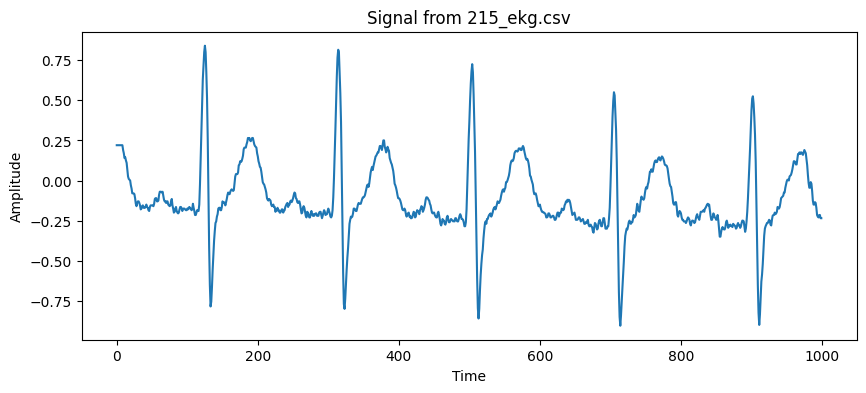

'MLII' data not found in 217_annotations_1.csv


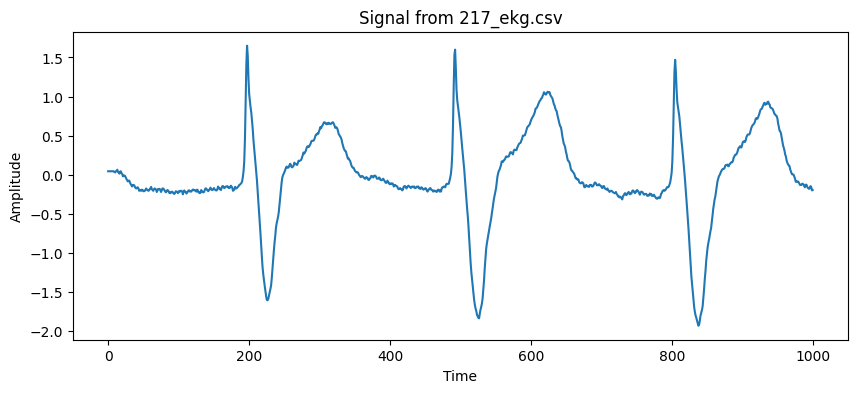

'MLII' data not found in 219_annotations_1.csv


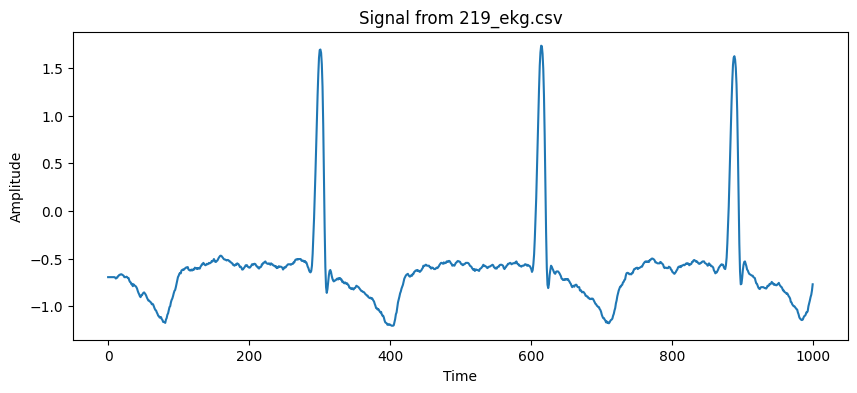

'MLII' data not found in 220_annotations_1.csv


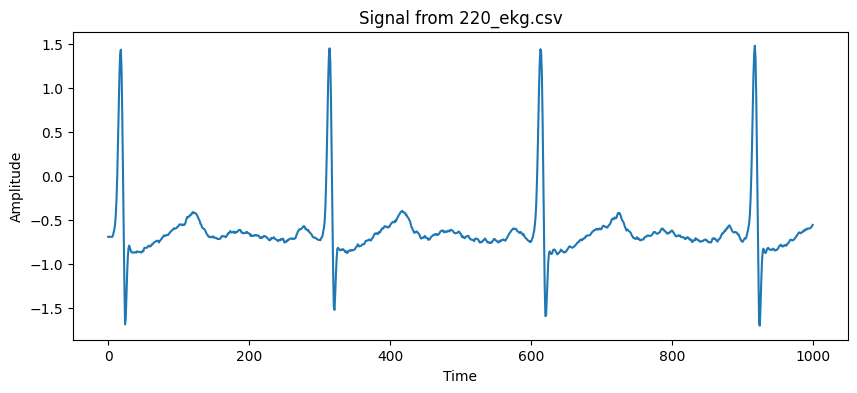

'MLII' data not found in 221_annotations_1.csv


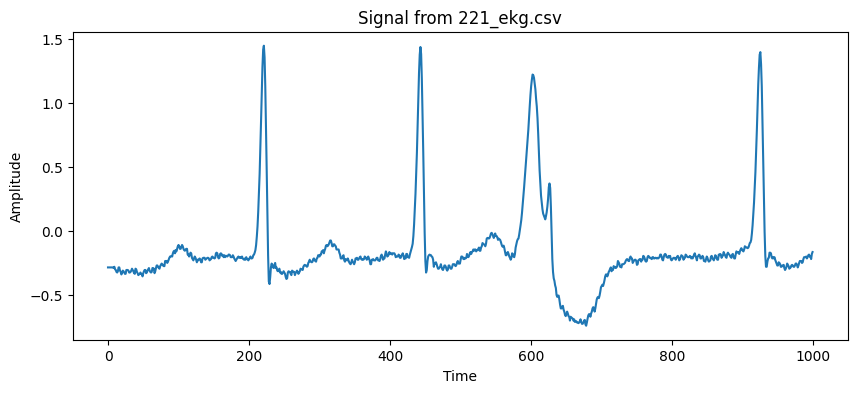

'MLII' data not found in 222_annotations_1.csv
'MLII' data not found in 222_annotations_2.csv


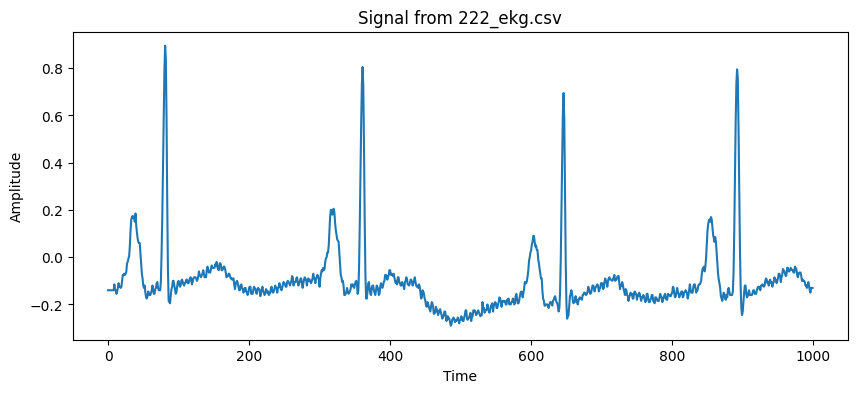

'MLII' data not found in 223_annotations_1.csv


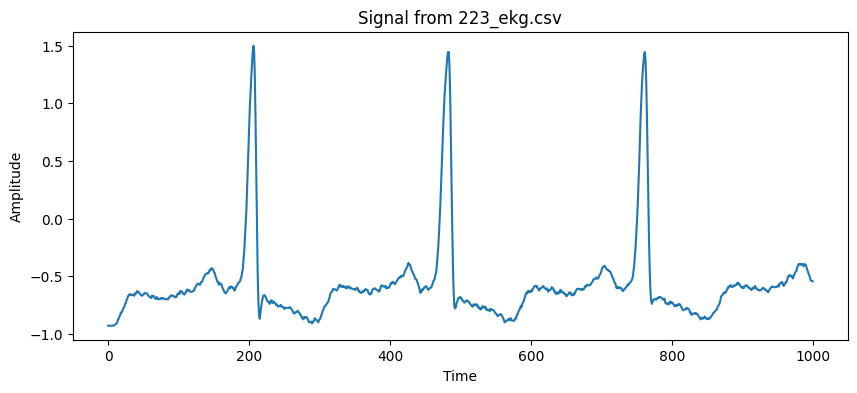

'MLII' data not found in 228_annotations_1.csv


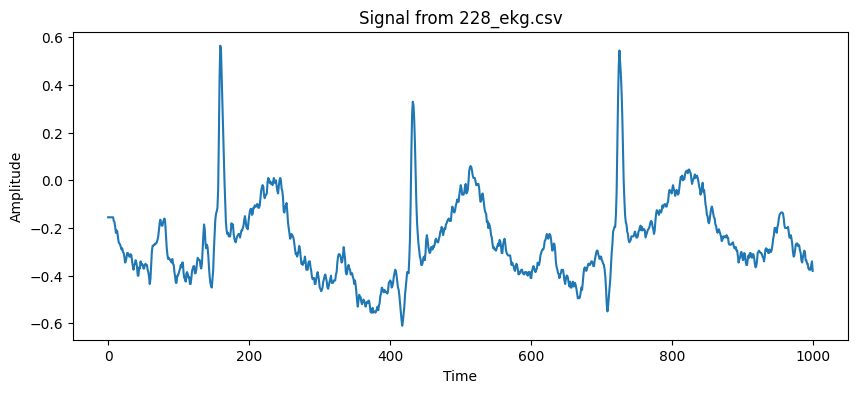

'MLII' data not found in 230_annotations_1.csv


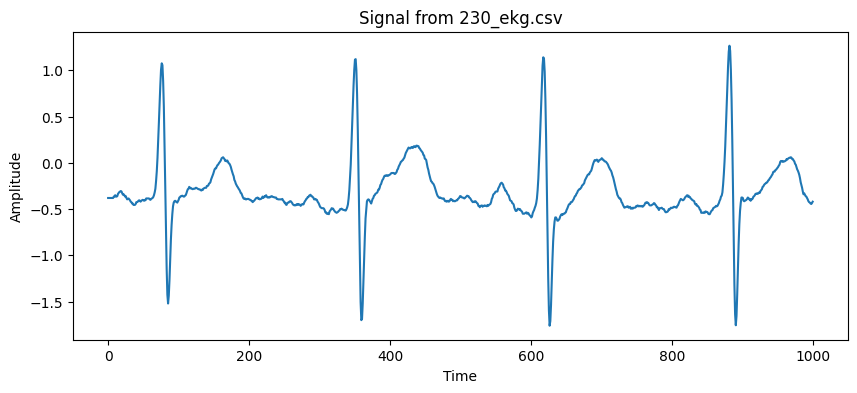

'MLII' data not found in 231_annotations_1.csv


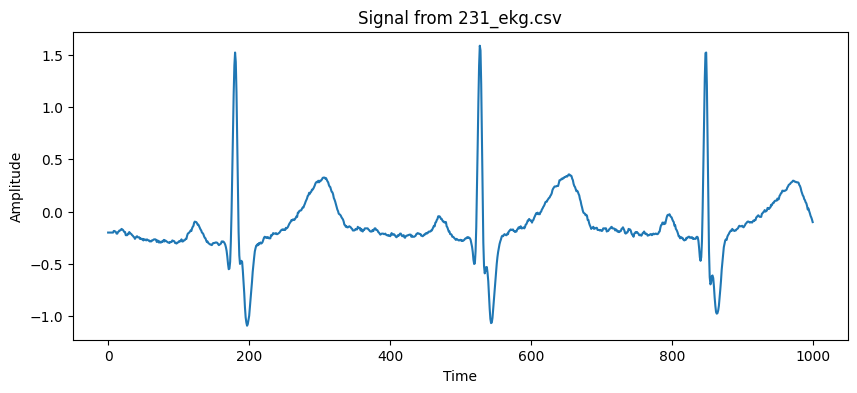

'MLII' data not found in 232_annotations_1.csv


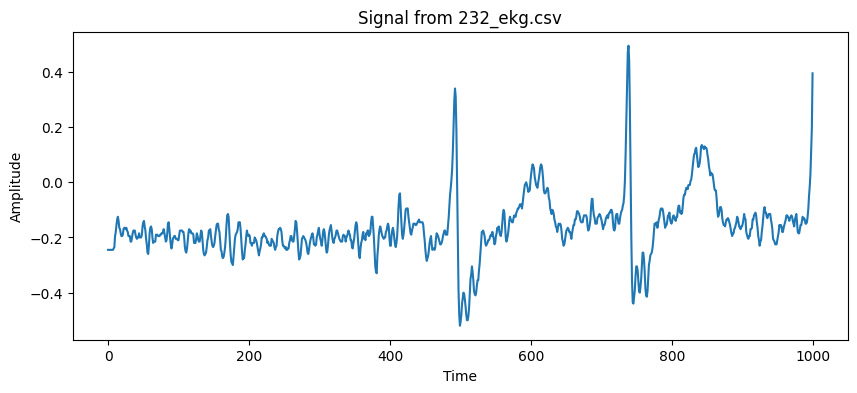

'MLII' data not found in 233_annotations_1.csv


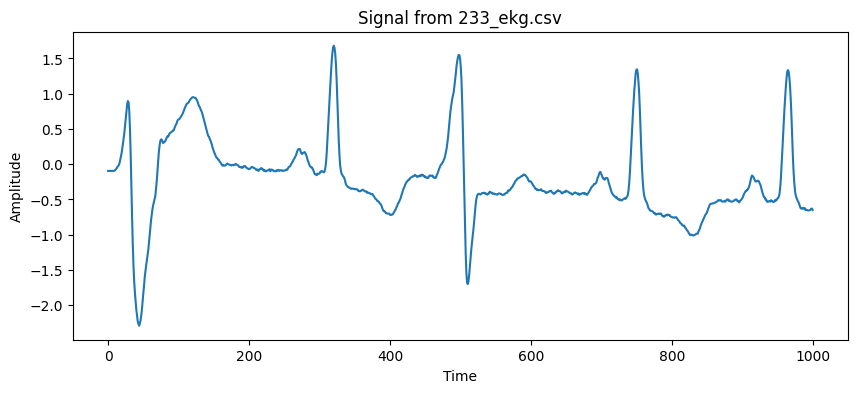

'MLII' data not found in 234_annotations_1.csv


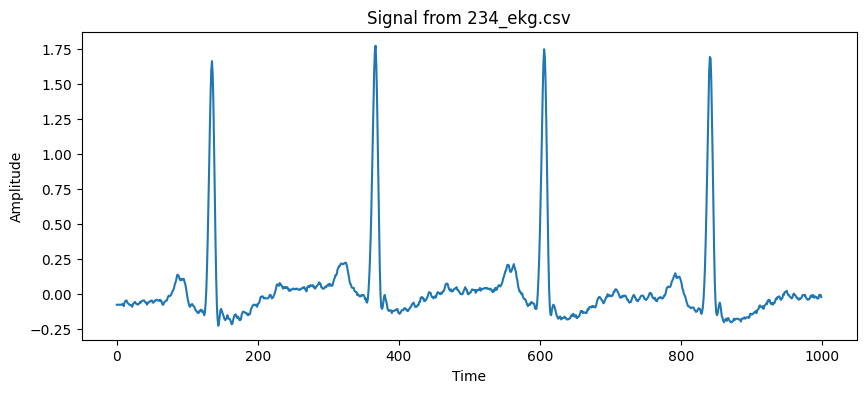

'MLII' data not found in annotation_symbols.csv


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "./data"
SIGNAL = "MLII"
file_names = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]

all_data = {}

# visualize desired signal (first 1000 samples)
for file_name in file_names:
    file_path = os.path.join(DATA_DIR, file_name)
    data = pd.read_csv(file_path)
    all_data[file_name] = data
    if SIGNAL in data.columns:
        plt.figure(figsize=(10, 4))
        plt.plot(data[SIGNAL][:1000])
        plt.title(f"Signal from {file_name}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()
    else:
        print(f"'{SIGNAL}' data not found in {file_name}")
        

### Resampling & Normalization

In [3]:
from scipy.signal import resample

TARGET_SAMPLING_RATE = 1000
standardized_signals = []

# resampling: standardize signal sampling rate to 1000 samples
for file_name, data in all_data.items():
    if SIGNAL in data:
        signal = data[SIGNAL].values
        resampled_signal = resample(signal, TARGET_SAMPLING_RATE)
        standardized_signals.append(resampled_signal)
    else:
        print(f"'{SIGNAL}' data not found in {file_name}")


'MLII' data not found in 100_annotations_1.csv
'MLII' data not found in 101_annotations_1.csv
'MLII' data not found in 102_annotations_1.csv
'MLII' data not found in 102_ekg.csv
'MLII' data not found in 103_annotations_1.csv
'MLII' data not found in 104_annotations_1.csv
'MLII' data not found in 104_ekg.csv
'MLII' data not found in 105_annotations_1.csv
'MLII' data not found in 106_annotations_1.csv
'MLII' data not found in 107_annotations_1.csv
'MLII' data not found in 108_annotations_1.csv
'MLII' data not found in 108_annotations_2.csv
'MLII' data not found in 109_annotations_1.csv
'MLII' data not found in 111_annotations_1.csv
'MLII' data not found in 112_annotations_1.csv
'MLII' data not found in 113_annotations_1.csv
'MLII' data not found in 114_annotations_1.csv
'MLII' data not found in 115_annotations_1.csv
'MLII' data not found in 116_annotations_1.csv
'MLII' data not found in 117_annotations_1.csv
'MLII' data not found in 117_annotations_2.csv
'MLII' data not found in 118_anno

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# scaling: fits signal values onto a range of -1, 1
normalized_signals = []
for signal in standardized_signals:
    signal = signal.reshape(-1, 1)
    normalized_signal = scaler.fit_transform(signal).flatten()
    normalized_signals.append(normalized_signal)


### Noise Reduction & Filtering

In [5]:
from scipy.signal import butter, filtfilt

# filtering: apply bandpass (has upper and lower cutoff) filter removes unwanted noise
def bandpass_filter(signal, low_cutoff=0.5, high_cutoff=50, fs=360, order=4):
    nyquist = 0.5 * fs
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_signals = [bandpass_filter(signal, low_cutoff=0.5, high_cutoff=50, fs=360) for signal in normalized_signals]


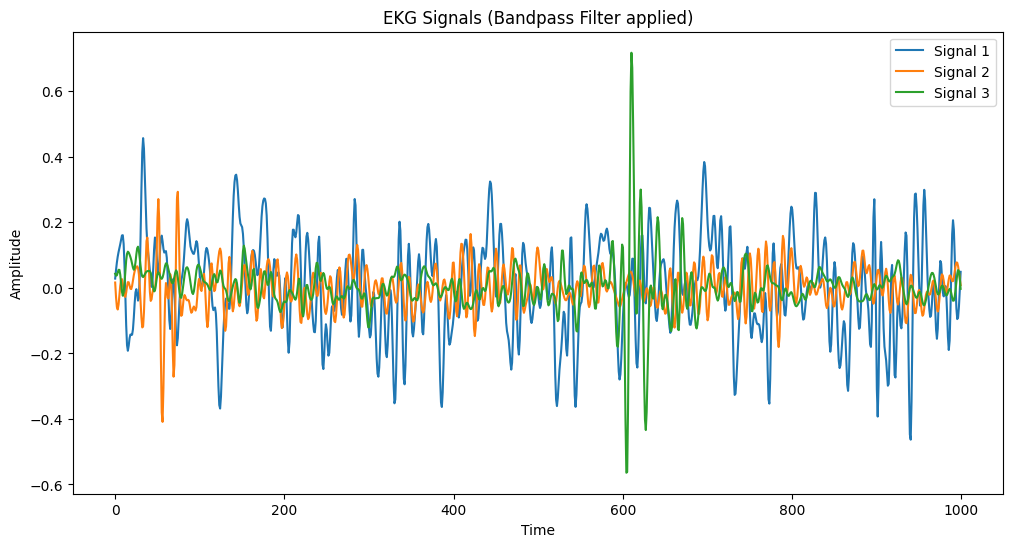

In [ ]:
# Visualize first 3 signals after bandpass filter
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, signal in enumerate(filtered_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Processed EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [14]:
# filtering: apply bandpass (has upper and lower cutoff) filter removes unwanted noise
def bandpass_filter(signal, low_cutoff=0.5, high_cutoff=40, fs=360, order=4):
    nyquist = 0.5 * fs
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_signals = [bandpass_filter(signal, low_cutoff=0.5, high_cutoff=40, fs=360) for signal in standardized_signals]


In [15]:
import numpy as np

# smoothing: apply moving averages to mitigate high frequency spikes
def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

smoothed_signals = [moving_average(signal, window_size=5) for signal in filtered_signals]


In [18]:
from sklearn.preprocessing import MinMaxScaler

# scaling: rescale values to -1, 1 range
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_signals = [scaler.fit_transform(signal.reshape(-1, 1)).flatten()
                      for signal in smoothed_signals]


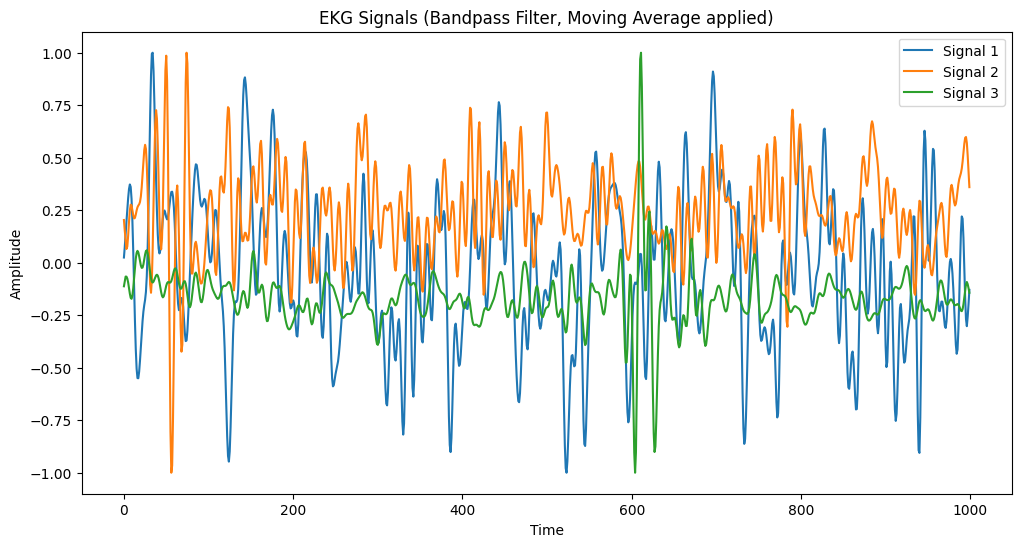

In [ ]:
# Visualize first 3 signals after bandpass filter > bandpass filter > moving average

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, signal in enumerate(normalized_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Cleaned and Smoothed EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [21]:
# filtering: apply bandpass (has upper and lower cutoff) filter removes unwanted noise
def bandpass_filter(signal, low_cutoff=0.5, high_cutoff=50, fs=360, order=4):
    nyquist = 0.5 * fs
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_signals = [bandpass_filter(signal, low_cutoff=0.5, high_cutoff=50, fs=360) for signal in standardized_signals]


In [22]:
from scipy.signal import savgol_filter

# smoothing: apply low pass filter (has an upper cutoff), Savitzky-Golay, to remove high frequency noise
smoothed_signals = [savgol_filter(signal, window_length=11, polyorder=3) for signal in filtered_signals]


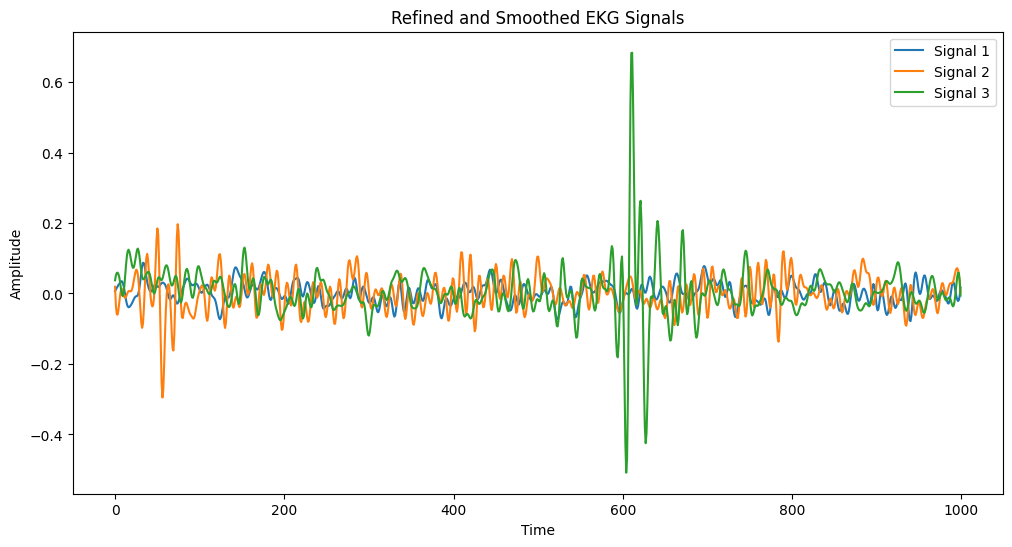

In [ ]:
# Visualize first 3 signals after bandpass filter > bandpass filter > moving average > bandpass filter > savgolfilter
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, signal in enumerate(smoothed_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Refined and Smoothed EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


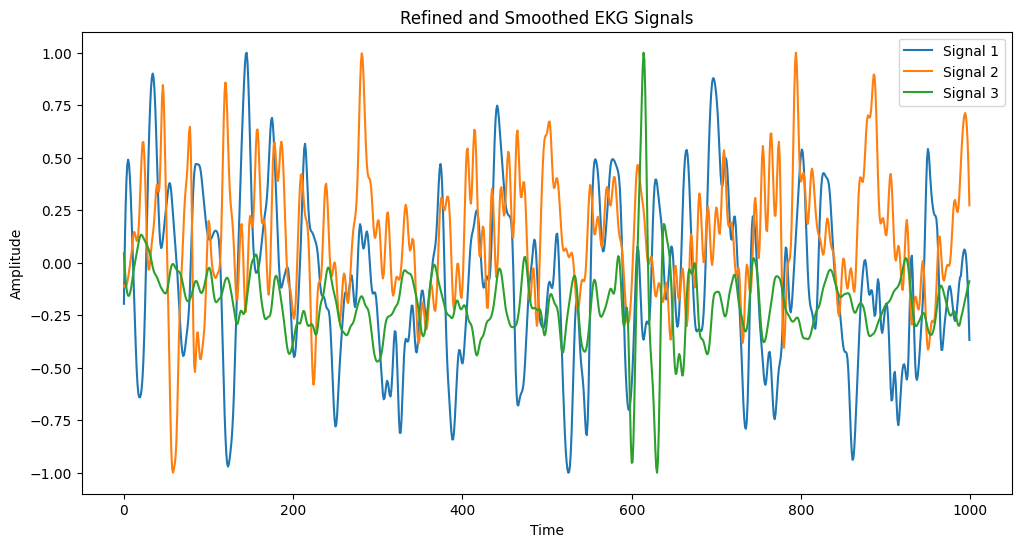

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, signal in enumerate(normalized_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Refined and Smoothed EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [ ]:
from scipy.signal import savgol_filter

# smoothing: apply low pass filter (has an upper cutoff), Savitzky-Golay, to remove high frequency noise
smoothed_signals = [savgol_filter(signal, window_length=21, polyorder=3) for signal in filtered_signals]

In [26]:
from sklearn.preprocessing import MinMaxScaler

# scaling: rescale signals to -1,1 range
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_signals = [scaler.fit_transform(signal.reshape(-1, 1)).flatten() for signal in smoothed_signals]


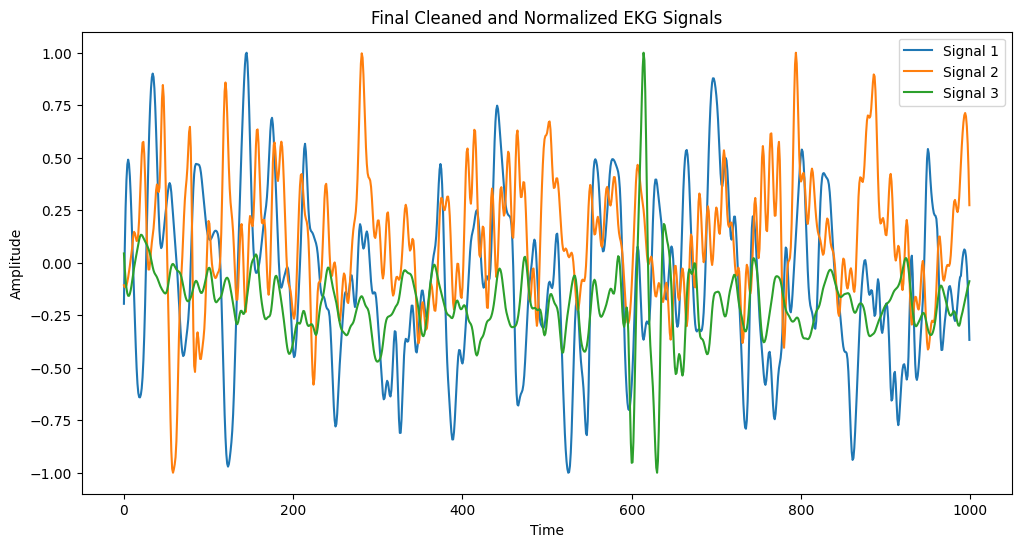

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i, signal in enumerate(normalized_signals[:3]):
    plt.plot(signal, label=f"Signal {i+1}")
plt.title("Final Cleaned and Normalized EKG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
